In [1]:
%load_ext autoreload
%autoreload 2

In [34]:
from logging import getLogger
from pathlib import Path
from pprint import pprint

import numpy as np
import pandas as pd
from datasets import load_dataset
from scipy.special import entr, softmax
from transformers import AutoModelForSequenceClassification, AutoTokenizer

from energizer.datastores import PandasDataStoreForSequenceClassification
from src.utilities import downsample_positive_class

logger = getLogger("log")

In [3]:
ds_dict = load_dataset("pietrolesci/wiki_toxic_indexed")
ds_dict = downsample_positive_class(
    dataset_dict=ds_dict,
    target_name="labels",
    positive_class=1,
    proportion=0.05,
    seed=42,
    logger=logger,
)

Found cached dataset parquet (/home/pl487/.cache/huggingface/datasets/pietrolesci___parquet/pietrolesci--wiki_toxic_indexed-bbeb1b8d65bf4665/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
ds = PandasDataStoreForSequenceClassification()
ds.from_dataset_dict(
    ds_dict,
    input_names=["text"],
    target_name="labels",
    uid_name="uid",
)

In [5]:
emb_name = "embedding_all-mpnet-base-v2"
ds.add_index(emb_name)

In [7]:
pos = ds.data.loc[ds.data["labels"] == 1]

In [6]:
q = np.stack(ds.get_by_ids([0, 1])["embedding_all-mpnet-base-v2"].tolist())
q

array([[ 0.03557768,  0.08102915, -0.03125104, ...,  0.03072219,
        -0.02192458, -0.04189122],
       [ 0.03733224, -0.04470239, -0.00302745, ..., -0.04228127,
        -0.03001823, -0.04983752]], dtype=float32)

In [29]:
i, d = ds.search(q, query_in_set=True, query_size=10)

<Axes: >

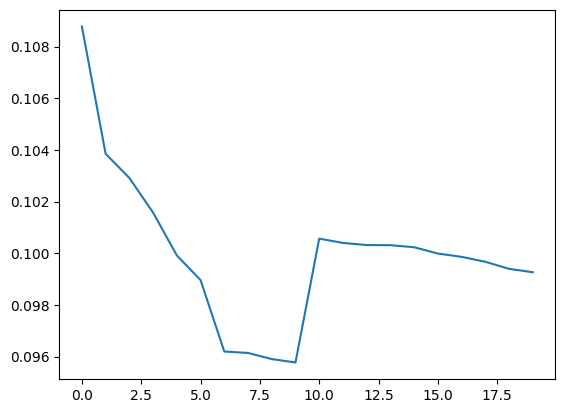

In [47]:
temperature = 1.0
scores = (1 - d) / temperature
probs = softmax(scores, axis=1)
pd.Series(probs.flatten()).plot()

In [76]:
i.flatten().shape

(20,)

In [77]:
(np.array([0, 1]).reshape(-1, 1) * np.ones_like(i, dtype=int)).flatten().shape

(20,)

In [88]:
np.repeat([0, 1], i.shape[1], axis=0)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [59]:
i

array([[     0, 106299,  98607,  28341,  83346, 110768, 152944,  95073,
          7388, 144084],
       [ 76480, 140855, 123174,  70501,   3017,  31091,  75286, 143852,
         78879,  23374]], dtype=uint64)

In [36]:
v, d = ds.search(np.stack(pos[emb_name].values), query_size=100, query_in_set=False)

In [37]:
ids = v.flatten()[d.flatten().argsort()]
_, udx = np.unique(ids, return_index=True)
oids = ids[np.sort(udx)]

In [44]:
d.flatten()

array([0.        , 0.38928115, 0.39933622, ..., 0.59810585, 0.59940755,
       0.5995972 ], dtype=float32)

array([151024, 140956,  25290, ...,  16463,  93068,   3634], dtype=uint64)

In [40]:
np.array([1, 2, 3]).argsort()

array([0, 1, 2])

In [38]:
oids.shape, ids.shape

((106278,), (967300,))

In [ ]:
pos.iloc[2, 1]

In [ ]:
ds.get_by_ids(oids)

In [ ]:
v_flat = np.unique(v[:, :10].flatten()).tolist()
ds.get_by_ids(v_flat)["labels"].value_counts()

In [ ]:
v.shape

In [ ]:
df = ds.get_by_ids(v_flat)
for t in df.loc[df["labels"] == 0, "comment_text"].sample(30).tolist():
    pprint(f"{t}\n========")